In [2]:
%run ../prepare_data.py -N_users 10

D:\Users\greg_\Anaconda3\lib\site-packages\pandas\core\indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
D:\Users\greg_\Anaconda3\lib\site-packages\pandas\core\indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [3]:
sequence = transform_users(
    users.user_id.sample(100)
)
df_train = sequence

print(df_train.shape)

D:\Users\greg_\Anaconda3\lib\site-packages\pandas\core\indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
D:\Users\greg_\Anaconda3\lib\site-packages\pandas\core\indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(18705, 82)


In [4]:
sequence = transform_users(
    users.user_id.sample(10)
)
df_test = sequence

print(df_test.shape)

D:\Users\greg_\Anaconda3\lib\site-packages\pandas\core\indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
D:\Users\greg_\Anaconda3\lib\site-packages\pandas\core\indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(1855, 82)


In [67]:
from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.optimizers import RMSprop, adam
from keras.utils.data_utils import get_file
from keras.callbacks import History, ModelCheckpoint
import numpy as np
import pandas as pd
import random
import sys
import string
import matplotlib.pyplot as plt
%matplotlib inline


# Define number of inputs/outputs to handle
input_size = 16
output_size= 16

# Load the train data
...

print('Train total outputs:', output_size)

# Pre-process the data (normalize)

# cut the input in semi-redundant sequences of maxlen characters
maxlen = 60
step_days = 3



def reformat(df_in):
    max_sequences = 10**5
    days_sequence = np.empty((max_sequences,maxlen,input_size),dtype=int)
    next_day = np.empty((max_sequences,output_size),dtype=int)
    days = df_in[:,-1]
    df = df_in[:,:-1]
    
    j=0
    last_day = 0
    for day_i in range(0, df.shape[0] - maxlen, step_days):
        if last_day < days[day_i+maxlen]:
            days_sequence[j] = df[day_i: day_i + maxlen,:input_size]
        next_day[j] = df[day_i + maxlen,:output_size]
        j += 1
        last_day = days[day_i]

    days_sequence = days_sequence[:j,:,:]
    next_day = next_day[:j,:]
    
    return days_sequence,next_day

X_train, y_train = reformat(df_train)
X_test,y_test=reformat(df_test)

print(df_train.shape,df_test.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

Train total outputs: 16
(18705, 82) (1855, 82)
(6215, 60, 16)
(6215, 16)
(599, 60, 16)
(599, 16)


In [68]:
def plot_logs(history):
    """
    Plot the accuracy and loss for 
        training and test sets
    """
    evaluation_cost = history.history['val_loss']
    evaluation_accuracy = history.history['val_acc']
    training_cost = history.history['loss']
    training_accuracy = history.history['acc']
    f, (ax1, ax2) = plt.subplots(1, 2)
    f.set_figwidth(10)
    ax1.plot(evaluation_cost,label= 'test')
    ax1.plot(training_cost, label='train')
    ax1.set_title('Cost')
    ax1.legend()
    ax2.plot(evaluation_accuracy, label='test')
    ax2.plot(training_accuracy, label='train')
    ax2.set_title('Accuracy')
    ax2.legend(loc='lower right')


def sample(preds, temperature=1.0):
    """
    Generate the next sequence
    Low temperature means very conservative (picks more probable most of the time)
    High temperature means very adventurous (picks less probable more frequently)
    """
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def generate_prediction(history,days=28, maxlen=60, input_size=16, output_size=16, diversity=1):
    """
    Generates as many days of prediction as requested
    Considers maxlen days of past history (must be aligned with model)
    """
    generated = np.zeros((days,input_size))
    if history.shape[1]>maxlen:
        x = history[:,-61:-1,:input_size]
    else:
        x = history[:,:,:output_size]
    #print(x.shape)
    for i in range(days):
        #print("Day %d" % i)
        preds = model.predict(x, verbose=0)[0].reshape(output_size)
        print(preds.shape)
        #next_symptoms = sample(preds, diversity)
        next_symptoms = preds
        #print(next_symptoms)

        generated[i,:] = next_symptoms
        x[:,:maxlen-1,:] = x[:,1:,:]
        x[:,maxlen-1,:] = next_symptoms

    return generated

Build model...
Train on 6215 samples, validate on 599 samples
Epoch 1/3
6215/6215 [==============================] - 3s - loss: 0.5471 - acc: 0.8707 - val_loss: 0.2880 - val_acc: 0.9684
Epoch 2/3
6215/6215 [==============================] - 1s - loss: 0.1608 - acc: 0.9832 - val_loss: 0.1422 - val_acc: 0.9684
Epoch 3/3
6215/6215 [==============================] - 2s - loss: 0.0860 - acc: 0.9832 - val_loss: 0.1482 - val_acc: 0.9684
Test score: 0.148177833957
Test accuracy: 0.968384805327


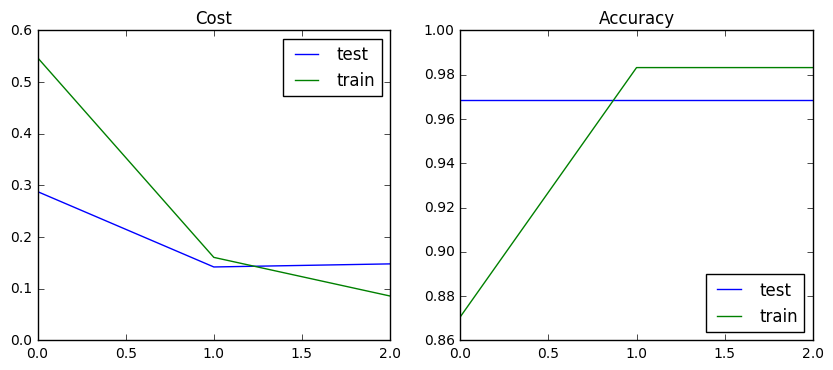

In [70]:
# Model params
batch_size = 512
nb_epoch = 3
np.random.seed(131078)

# build the model
print('Build model...')


filepath="lstm_1_layer.hdf5"
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, input_size)))
model.add(Dense(output_size))
model.add(Activation('sigmoid'))

"""
filepath="lstm_2_layers.hdf5"
model = Sequential()
model.add(LSTM(256, input_shape=(maxlen, input_size), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dropout(0.1))
model.add(Dense(output_size))
model.add(Activation('sigmoid'))
"""

optimizer = adam()
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer,
              metrics=['accuracy'])

# Define callback to save model
save_snapshots = ModelCheckpoint(filepath,
                                 monitor='loss',
                                 save_best_only=True,
                                 save_weights_only=True,
                                 mode='min',
                                 verbose=0)
callbacks_list = [save_snapshots]

history = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    nb_epoch=nb_epoch,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=1)          

score = model.evaluate(X_test, y_test, verbose=2)
print('Test score:', score[0])
print('Test accuracy:', score[1])  

plot_logs(history)          


In [71]:
hist = X_test[0,:,:].reshape(1,60,-1)
print(hist.shape)
res = generate_prediction(hist,maxlen=maxlen,input_size=input_size,output_size=output_size)
res.shape

(1, 60, 16)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)


(28, 16)

In [72]:
res[:,:output_size]

array([[ 0.02090395,  0.0089205 ,  0.0084583 ,  0.01231497,  0.00634355,
         0.00662608,  0.01039723,  0.01105994,  0.0277781 ,  0.0113249 ,
         0.00584292,  0.01466934,  0.01626649,  0.00817325,  0.01360582,
         0.00998757],
       [ 0.02090394,  0.0089205 ,  0.0084583 ,  0.01231497,  0.00634355,
         0.00662608,  0.01039723,  0.01105994,  0.0277781 ,  0.01132491,
         0.00584292,  0.01466935,  0.01626649,  0.00817325,  0.01360582,
         0.00998757],
       [ 0.02090394,  0.00892049,  0.00845829,  0.01231497,  0.00634355,
         0.00662608,  0.01039723,  0.01105995,  0.0277781 ,  0.01132491,
         0.00584293,  0.01466934,  0.01626649,  0.00817325,  0.01360582,
         0.00998757],
       [ 0.02090393,  0.00892049,  0.00845829,  0.01231496,  0.00634355,
         0.00662608,  0.01039723,  0.01105995,  0.02777808,  0.01132491,
         0.00584292,  0.01466935,  0.01626649,  0.00817326,  0.01360582,
         0.00998757],
       [ 0.02090392,  0.00892049,  0

In [20]:
y_test[:28,:output_size]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0,